## **NOTES**

Bu projede; data, labels ve data.h5 "CNN + BILSTM" klas√∂r√ºnden √ßekilmi≈ütir.

Sonu√ßlar ise "CNN + BILSTM Advenced" klas√∂r√ºne kayƒ±t edilmi≈ütir.

G√∂zlemlenmeye √ßalƒ±≈üƒ±lan ekstra teknikler Notes kƒ±smƒ±ndaki √∂ncelikli √∂neri teknikleridir.

**√ñNCELƒ∞KLƒ∞**

Class Weight	√ñzellikle Hip-Hop, Jazz, International, Spoken gibi daha az
sayƒ±da √∂rneƒüe sahip sƒ±nƒ±flarda recall ve precision d√º≈ü√ºk. Class weight ile modelin nadir sƒ±nƒ±flarƒ± daha √∂nemsemesini saƒülarsƒ±n.

Data Augmentation (Veri Artƒ±rƒ±mƒ±)	Yine nadir sƒ±nƒ±flar i√ßin veri artƒ±rƒ±mƒ± (SpecAugment, pitch shift, time stretch) √ßok faydalƒ±. √ñzellikle Spoken, Jazz, Hip-Hop gibi sƒ±nƒ±flarda performansƒ± artƒ±rƒ±r.

Veri Artƒ±rƒ±mƒ± (ImageDataGenerator Geli≈ütirme)	≈ûu an sade ImageDataGenerator kullanmƒ±≈üsƒ±n, ama mel-spectrogram √ºzerinde frekans ve zaman ekseni augmentasyonlarƒ± (√∂r. frequency masking, time masking) √∂zellikle ses t√ºr√º i√ßin g√º√ßl√º katkƒ± saƒülar.

Attention Layer (BiLSTM sonrasƒ±)	≈ûu an BiLSTM kullanƒ±yorsun, ama hangi zaman aralƒ±klarƒ±nƒ±n √∂nemli olduƒüunu fark etmesini saƒülamak i√ßin Attention eklemek √ßok etkili olur. Zaman serileri i√ßin olmazsa olmaz hale geldi.

EarlyStopping ve ModelCheckpoint	Mevcut model √ßok g√ºzel √∂ƒüreniyor ancak overfitting riski her zaman var. Validation loss takip ederek gereksiz uzayan epochlarƒ± engeller. Ayrƒ±ca en iyi modeli kaydedersin.


**ƒ∞Kƒ∞NCƒ∞L**

Learning Rate Scheduler	Zaten iyi bir eƒüri var ama sonlara doƒüru "plateau" olursa learning rate d√º≈ü√ºrerek daha iyi minimuma inebilirsin. Performansƒ± daha da iyile≈ütirebilir.

Batch Normalization	Training s√ºrecini stabilize eder, ancak zaten iyi √∂ƒüreniyorsun. Overfitting sorunu ya≈üarsan ekleyebilirsin.

Regularization (L2, Dropout Artƒ±rƒ±mƒ±)	%90 doƒüruluk zaten g√ºzel, ama overfitting ba≈ülarsa veya validation ile train farkƒ± a√ßƒ±lƒ±rsa L2 ekleyebilirsin.

Adam yerine AdamW	≈ûu an Adam ile iyi sonu√ß almƒ±≈üsƒ±n. A≈üƒ±rƒ± overfitting g√∂zlemlenirse AdamW'a ge√ßilebilir. √áok kritik deƒüil.

## **Importing Libraries & Parameter Setup**

In [1]:
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [2]:
import os
import h5py
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import shutil
import soundfile as sf
import pandas as pd
import random
import h5py
from google.colab import files
from pydub import AudioSegment
from tqdm import tqdm
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, Reshape, Bidirectional, LSTM,
                                     Multiply, GlobalAveragePooling2D, Dense, Reshape)
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")

chunk_duration = 4
overlap_duration = 2
target_sr = 22050
target_shape = (128, 128)
n_mels = 128
fmax = 8000
batch_size = 100

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

## **Dataset Inspect**

In [5]:
dataset_path = "/content/drive/MyDrive/FMA_DATASET"
small_audio_path = os.path.join(dataset_path, "fma_small_wav/fma_small")
metadata_path = os.path.join(dataset_path, "fma_metadata")
tracks_csv_path = os.path.join(metadata_path, "tracks.csv")

small_track_ids = []

for folder in os.listdir(small_audio_path):
    folder_path = os.path.join(small_audio_path, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.wav'):
                track_id = int(filename.split('.')[0])
                small_track_ids.append(track_id)

print(f"üéµ fma_small i√ßinde bulunan ≈üarkƒ± ID sayƒ±sƒ±: {len(small_track_ids)}")

if os.path.exists(tracks_csv_path):
    tracks_df = pd.read_csv(tracks_csv_path, index_col=0, header=[0, 1])

    genre_data = tracks_df.loc[small_track_ids, [("track", "genre_top")]].dropna()
    genre_data.columns = ["genre_top"]

    genre_counts = genre_data["genre_top"].value_counts()

    print("\nüéØ fma_small klas√∂r√ºndeki ≈ûarkƒ± T√ºr Daƒüƒ±lƒ±mƒ±:")
    print(genre_counts)
else:
    print("‚ö† tracks.csv dosyasƒ± bulunamadƒ±!")

üéµ fma_small i√ßinde bulunan ≈üarkƒ± ID sayƒ±sƒ±: 7997

üéØ fma_small klas√∂r√ºndeki ≈ûarkƒ± T√ºr Daƒüƒ±lƒ±mƒ±:
genre_top
International    1000
Hip-Hop          1000
Pop              1000
Folk             1000
Instrumental     1000
Experimental      999
Rock              999
Electronic        999
Name: count, dtype: int64


In [6]:
classes = [
    "Pop", "Instrumental", "International", "Hip-Hop",
    "Folk", "Experimental", "Rock", "Electronic"
]

## **Splitting Dataset into Training and Test Set**

In [ ]:
load_path = "/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/"

data = np.load(os.path.join(load_path, "data.npy"))
labels = np.load(os.path.join(load_path, "labels.npy"))

print("‚úÖ Veriler ba≈üarƒ±yla y√ºklendi!")
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

In [7]:
x_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTrain.npy'
y_train_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTrain.npy'
x_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/XTest.npy'
y_test_path = '/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN/YTest.npy'

XTrain = np.load(x_train_path)
YTrain = np.load(y_train_path)
XTest = np.load(x_test_path)
YTest = np.load(y_test_path)

In [8]:
XTrain[0].shape

(128, 128, 1)

## **Data Generation**

In [9]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(XTrain, YTrain, batch_size=32)
test_generator = test_datagen.flow(XTest, YTest, batch_size=32)

## **Model Definition**

In [10]:
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([input_tensor, se])

In [11]:
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1), initializer='normal')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros')
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [12]:
model = Sequential()

# --- CNN Blocks ---
input_shape = (128, 128, 1)

model.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Dropout(0.3))

model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Reshape((4, 512)))

# --- BiLSTM ---
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Attention())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                      ‚îÇ (None, 128, 128, 32)        ‚îÇ             320 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)                    ‚îÇ (None, 128, 128, 32)        ‚îÇ           9,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)         ‚îÇ (None, 64, 64, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)                    ‚îÇ (None, 64, 64, 64)          ‚îÇ          18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)                    ‚îÇ (None, 62, 62, 64)          ‚îÇ          36,928 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)       ‚îÇ (None, 31, 31, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_4 (Conv2D)                    ‚îÇ (None, 31, 31, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_5 (Conv2D)                    ‚îÇ (None, 29, 29, 128)         ‚îÇ         147,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)       ‚îÇ (None, 14, 14, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 14, 14, 128)         ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

 Total params: 5,602,668 (21.37 MB)

 Trainable params: 5,602,668 (21.37 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Compile**

In [13]:
model.compile(
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## **Model Train**

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Trained_Model_FMA_SMALL.keras',
                             monitor='val_loss', save_best_only=True, verbose=1)

trainingHistory = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2882/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 27ms/step - accuracy: 0.2792 - loss: 1.8427
Epoch 1: val_loss improved from inf to 1.47409, saving model to /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Trained_Model_FMA_SMALL.keras
2882/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 99s 29ms/step - accuracy: 0.2792 - loss: 1.8426 - val_accuracy: 0.4817 - val_loss: 1.4741
Epoch 2/20
2881/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 27ms/step - accuracy: 0.5082 - loss: 1.4055
Epoch 2: val_loss improved from 1.47409 to 1.27007, saving model to /content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Trained_Model_FMA_SMALL.keras
2882/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 82s 28ms/step - accuracy: 0.5082 - loss: 1.4055 - val_accuracy: 0.5572 - val_loss: 1.2701
Epoch 3/20
2881/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

## **Model & Train History Save**

In [15]:
model.save('/content/drive/MyDrive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Final_Trained_Model_FMAL_SMALL.keras')

In [16]:
import json
with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Training_History.json', 'w') as f:
    json.dump(trainingHistory.history, f)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Final_Trained_model_FMA_SMALL.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/Trained_model_FMA_SMALL.keras')

In [ ]:
import json

with open('/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_DATA/CNN + BILSTM Advenced/Training_History.json', 'r') as f:
    Training_History = json.load(f)

## **Model Evaluation**

In [17]:
eval_datagen = ImageDataGenerator()

train_eval_generator = eval_datagen.flow(XTrain, YTrain, batch_size=32)
test_eval_generator = eval_datagen.flow(XTest, YTest, batch_size=32)

trainLoss, trainAccuracy = model.evaluate(train_eval_generator)
valLoss, valAccuracy = model.evaluate(test_eval_generator)

print(f"Train Loss: {trainLoss}, Train Accuracy: {trainAccuracy}")
print(f"Validation Loss: {valLoss}, Validation Accuracy: {valAccuracy}")

  19/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 6ms/step - accuracy: 0.9925 - loss: 0.0204

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2882/2882 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 6ms/step - accuracy: 0.9936 - loss: 0.0198
721/721 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 6ms/step - accuracy: 0.8985 - loss: 0.4076
Train Loss: 0.020279761403799057, Train Accuracy: 0.9932438135147095
Validation Loss: 0.39296796917915344, Validation Accuracy: 0.9011884927749634


In [18]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/evaluation_results.json"

evaluation_results = {
    "train_loss": trainLoss,
    "train_accuracy": trainAccuracy,
    "val_loss": valLoss,
    "val_accuracy": valAccuracy
}

with open(results_path, "w") as json_file:
    json.dump(evaluation_results, json_file, indent=4)

In [ ]:
results_path = "/content/drive/My Drive/MUSIC GENRE CLASSIFICATION/FMA_SMALL_DATA/CNN + BILSTM Advenced/evaluation_results.json"

with open(results_path, "r") as json_file:
    evaluation_results = json.load(json_file)

trainLoss = evaluation_results["train_loss"]
trainAccuracy = evaluation_results["train_accuracy"]
valLoss = evaluation_results["val_loss"]
valAccuracy = evaluation_results["val_accuracy"]

## **Accuracy & Loss Visualization**

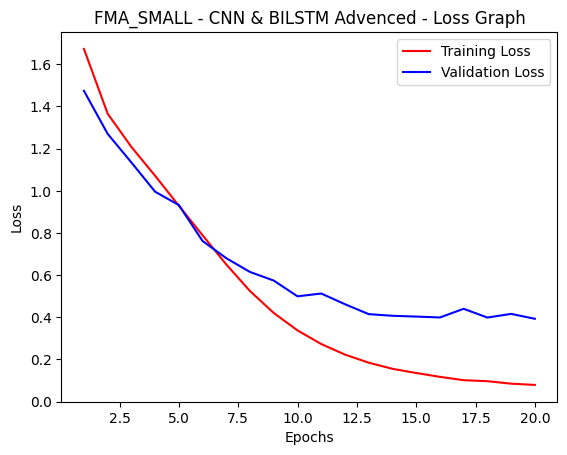

In [21]:
epochs = range(1, len(trainingHistory.history['loss']) + 1)

plt.plot(epochs, trainingHistory.history['loss'], label="Training Loss", color='red')
plt.plot(epochs, trainingHistory.history['val_loss'], label="Validation Loss", color='blue')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("FMA_SMALL - CNN & BILSTM Advenced - Loss Graph")
plt.legend()
plt.show()


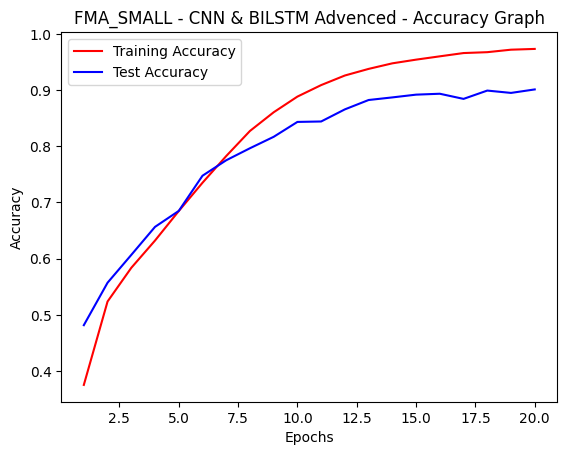

In [22]:
epochs = range(1, len(trainingHistory.history['loss']) + 1)

plt.plot(epochs, trainingHistory.history['accuracy'], label = "Training Accuracy", color = 'red')
plt.plot(epochs, trainingHistory.history['val_accuracy'], label = "Test Accuracy", color = 'blue')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("FMA_SMALL - CNN & BILSTM Advenced - Accuracy Graph")
plt.legend()
plt.show()

## **Metrics**

In [23]:
YPred = model.predict(XTest)
print("YPred Shape:", YPred.shape)

721/721 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 5ms/step
YPred Shape: (23054, 8)


In [24]:
predictedCategories = np.argmax(YPred, axis=1)
trueCategories = np.argmax(YTest, axis=1)

In [25]:
print("Predicted Categories:", predictedCategories)
print("True Categories:", trueCategories)

Predicted Categories: [5 2 4 ... 4 1 0]
True Categories: [5 6 4 ... 4 1 0]


In [26]:
cm = confusion_matrix(trueCategories, predictedCategories)
print(classification_report(trueCategories, predictedCategories, target_names=classes))

               precision    recall  f1-score   support

          Pop       0.88      0.83      0.85      2955
 Instrumental       0.89      0.90      0.90      2898
International       0.94      0.92      0.93      2802
      Hip-Hop       0.89      0.96      0.93      2910
         Folk       0.83      0.95      0.88      2959
 Experimental       0.90      0.87      0.89      2861
         Rock       0.97      0.88      0.92      2797
   Electronic       0.93      0.89      0.91      2872

     accuracy                           0.90     23054
    macro avg       0.90      0.90      0.90     23054
 weighted avg       0.90      0.90      0.90     23054



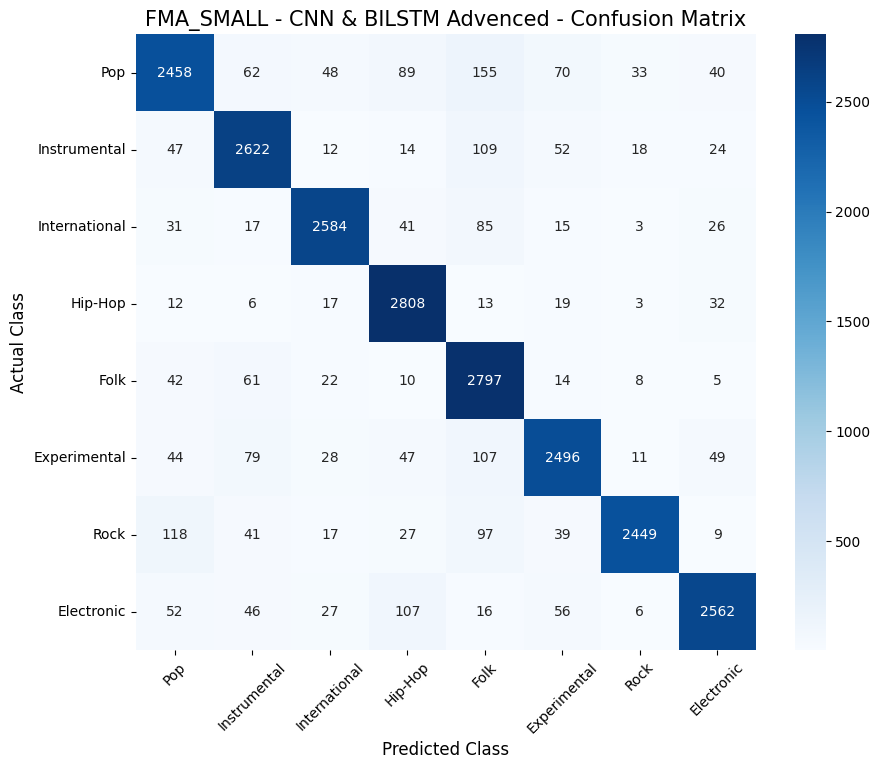

In [27]:
cm = confusion_matrix(trueCategories, predictedCategories)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("FMA_SMALL - CNN & BILSTM Advenced - Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

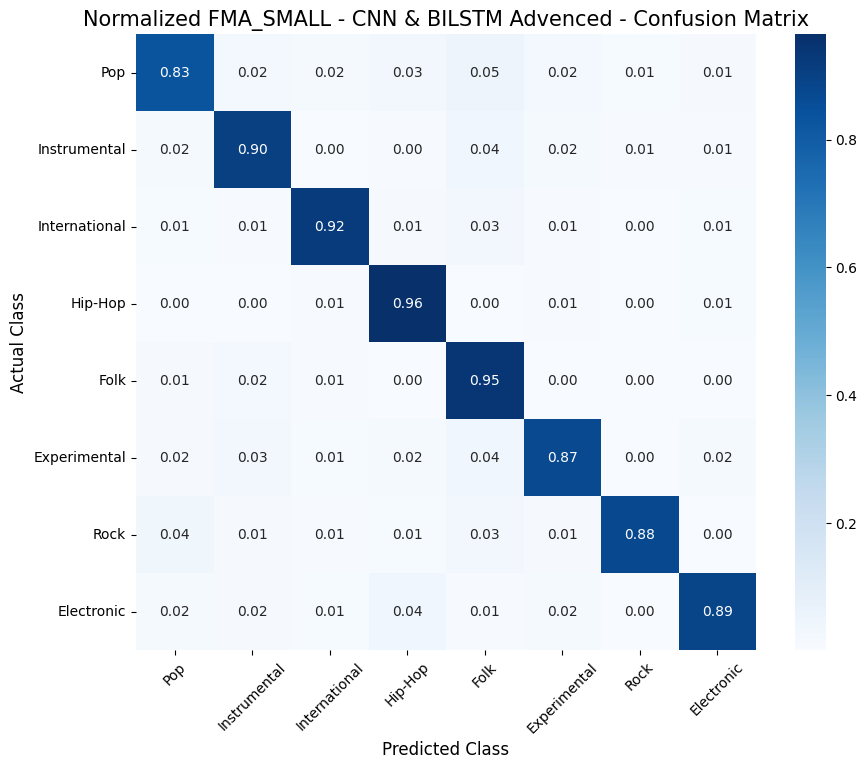

In [28]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("Actual Class", fontsize=12)
plt.title("Normalized FMA_SMALL - CNN & BILSTM Advenced - Confusion Matrix", fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()